# Analysis Script for Keys Online 
🐝


1. [Setting up libraries and definitions](#a1)
2. [Input Information and Setting up data storage](#2)
3. [Reading in data from CSV files](#3)
4. [Display a summary of the data](#4)
5. [Look at the training data](#5)
    6. [RT Across Training](#6)
    6. [Accuracy Across Days](#7)
6. [Orienting Results](#8)
    6. [RT for conditions and order](#9)
    6.  [Distribution of RTs](#10)
7. [Memtest Results](#11)
    7. [Experimenting with concatenated data structure](#12)
    7. [How accurate were clicks?](#13)
        7. [Cartesian Things](#14)
        7. [Confidence Accuracy](#15)

<a id='a1'></a>

## Setting up libraries and definitions
First we import the different Python libraries:

In [133]:
import os
import sys
import json
import re
import csv
import math
import pprint
import numpy as np
randn = np.random.randn
from numpy import nan
import pandas as pd 
from pandas import *
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import matplotlib
import scipy.stats as ss 
from scipy import stats, integrate

import seaborn as sns
sns.set(color_codes=True)

np.random.seed(sum(map(ord, "distributions")))



<a id='2'></a>

## Input information & set up data storage
Input participant numbers and location of folders. 

Invoke dictionary for data 

In [24]:
#Change this to whatever you need
input_dir = "/Users/Alex/Documents/Javascript_truecolours/Keys_Orienting/parsed/"
partno = [38, 37, 36, 35, 34, 33, 32, 30, 29, 28, 27, 25, 24, 23, 21, 20, 19, 18, 17, 16, 15, 14]
output_dir = "/Users/Alex/Documents/Javascript_truecolours/Keys_Orienting/results/"
config_dir = "/Users/Alex/Documents/Javascript_truecolours/Keys_Orienting/conf/"
#acknowledge directory
os.chdir(input_dir)
workingdirectory = input_dir

# This generates the empty dictionary in the desired nested format 
data = {}
for part in partno: 
    data[part] ={}
    for block in range(7): 
        data[part][block] = {}

<a id='3'></a>

## Read in data from CSV files 

Each session is read in as a panda.DataFrame in to the data dictionary, this gives the following structure:

    data[partno][blockno].field[trial]

So if I wanted to access participant 33, block 6 I would enter:

    data[33][6][0]
    
If I wanted just the image number in the first trial:

    data[33][6].image[0]

In [25]:
#Now we read in the actual CSV files: if data is missing it will be recorded as NaN
for part in partno:
    for block in range(10):
        
        try:
            #Reads the CSV file as a panda DataFrame into the Dict at the right location
            data[part][block] = pd.read_csv(input_dir + str(part) + '_' + str(block+1) + '.csv')
            #The parsing script sometimes makes empty files, with just headers. The line below checks if there is data in the read in CSV
            data[part][block].rename(columns= lambda x: x.replace(" ", ""), inplace=True)
            data[part][block]['image'][0]
        except:
            #if an exception is raised, the file does not exist or is corrupted 
            data[part][block] = {nan}


<a id='4'></a>

## Display a summary of the data 

We now need to return how complete each participants data is, we do this using the matplotlib


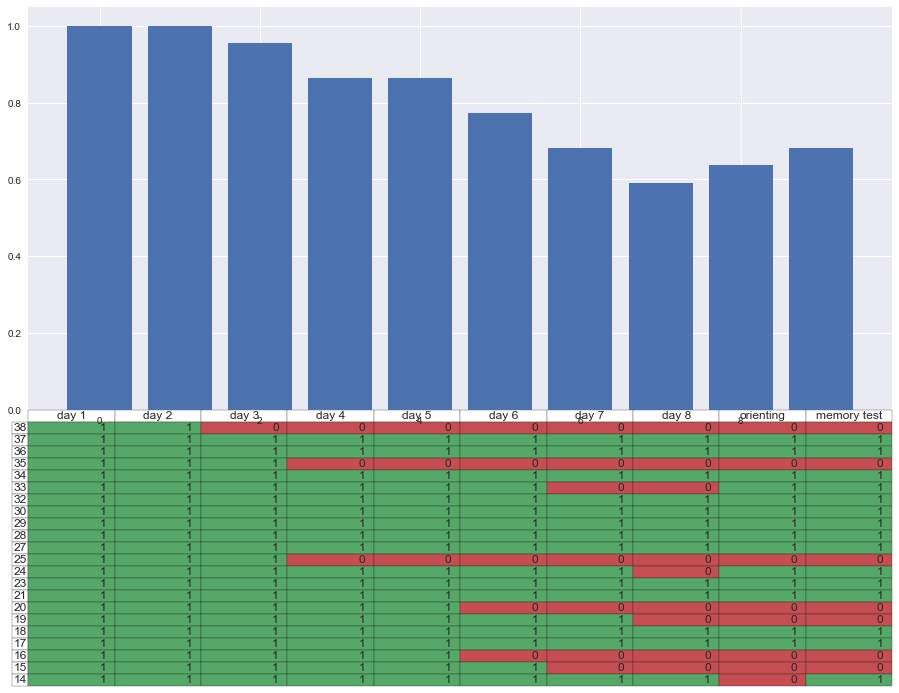

In [26]:
#Make a dataframe: participants x 10 blocks, set to 0
summary_mat = [[0 for x in range(10)] for y in range(len(data))]

#Loop through matrix and insert #1 if data is present
mt_cnt = 0
for part in partno:
    for block in range(10):
        #see if this block has more than one row of trial data
        try:
            data[part][block][:1]
            summary_mat[mt_cnt][block] = 1 
        except:
            pass
    mt_cnt +=1

#make the table
# define labels for columns and rows
columns = ('day 1', 'day 2', 'day 3', 'day 4', 'day 5', 'day 6', 'day 7', 'day 8', 'orienting', 'memory test')
rows = list(map(str, partno))
pads = matplotlib.figure.SubplotParams(left = 0.2, right = 1, bottom = 0.2, top = 1, wspace = 1, hspace = 1)
the_table = plt.figure(figsize=(15,7), subplotpars=pads)
#plot out the bar chart
the_table = plt.bar(range(10),  list((np.array(summary_mat)).mean(axis=0)))


#Make map for cell colours in the table (green = complete, red = absent)
cellcolours = np.empty_like(summary_mat, dtype='object')# empty array for colours
for r in range(len(summary_mat)): # loop through rows
    for c in range(len(summary_mat[0])): #loop through columns
        if summary_mat[r][c] == 1: #if data exists
            cellcolours[r,c] = 'g'
        else:                      #else there is not data
            cellcolours[r][c] = 'r'

#plot out the table 
the_table = plt.table(cellText=summary_mat,colLabels=columns, rowLabels=rows, cellColours=cellcolours)

#print the plot 
plt.show()



<a id='5'></a>

## Look at the training data 

Now let's look at how well the participants learnt each image in each order condition over the duration of training. 

We want to still include the participants with missing days so NaN this

In [27]:
data = pd.DataFrame(data)
rts = {}
rts_all = {}
#populate empty array
for day in range(8):
    rts[day] = {}
    rts_all[day] = {}
    for order in range(4):
        rts[day][order] = []
        rts_all[day][order] = []

#print(data[part][day](data[part][day]['correct'] == 1) & (data[part][day]['order']==1))
#append rows to array - exception if non existent (i.e. missing days)
for part in partno:
    for day in range(8):
        try:
            #only use correct trials 
            rts[day][0].append(np.array(data[part][day][(data[part][day]['order'] == 1) & (data[part][day]['correct'] == 1)]))
            rts[day][1].append(np.array(data[part][day][(data[part][day]['order'] == 2) & (data[part][day]['correct'] == 1)]))
            rts[day][2].append(np.array(data[part][day][(data[part][day]['order'] == 3) & (data[part][day]['correct'] == 1)]))
            rts[day][3].append(np.array(data[part][day][(data[part][day]['order'] == 4) & (data[part][day]['correct'] == 1)]))

            #use all trials 
            rts_all[day][0].append(np.array(data[part][day][data[part][day]['order'] == 1]))          
            rts_all[day][1].append(np.array(data[part][day][data[part][day]['order'] == 2]))
            rts_all[day][2].append(np.array(data[part][day][data[part][day]['order'] == 3]))
            rts_all[day][3].append(np.array(data[part][day][data[part][day]['order'] == 4]))
        except:
            pass 
        
#concat vertically all data in cells for each dayXcondition
for day in range(8):
    for order in range(4):
        rts[day][order] = np.vstack(rts[day][order])
        rts_all[day][order] = np.vstack(rts_all[day][order])

<a id='6'></a>

### RT Across Training 

Graph for looking at RT across training

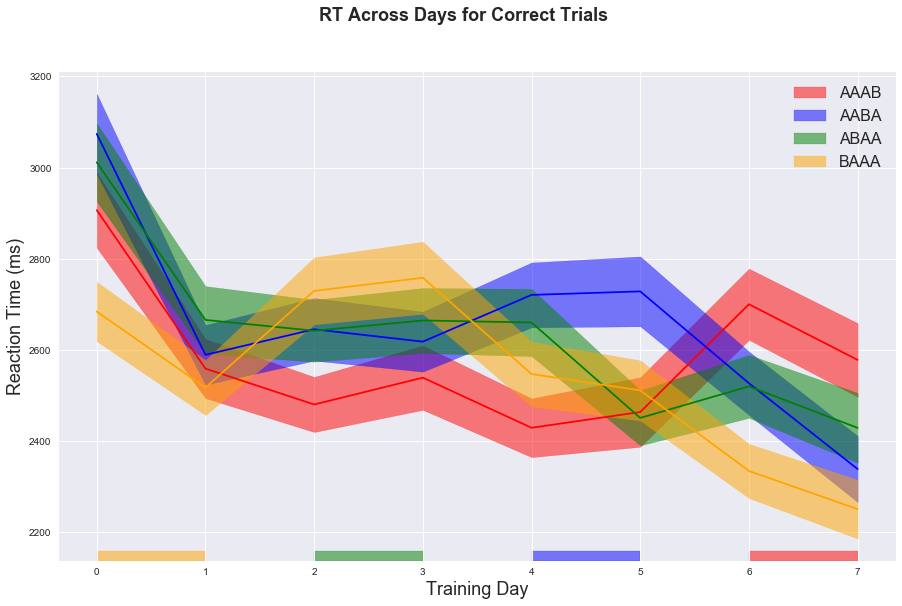

In [116]:
#make an array of means and SD (day x condition)   
means = np.zeros((8,4))
sd = np.zeros((8,4))
for day in range(8):
    for order in range(4):
        means[day, order] = np.mean(rts[day][order][:,5])#average RT
        sd[day, order] = ss.sem(rts[day][order][:,5])#Standard Error of the Mean 
        
#Plot the graph
rt_training = plt.figure(figsize=(15,9))
rt_training = plt.plot(range(len(means[:,0])), means[:,0], color = 'red')
rt_training = plt.fill_between(range(len(means[:,0])),means[:,0]-sd[:,0], means[:,0]+sd[:,0], alpha=0.5, color = 'red')
rt_training = plt.axvspan(6, 7, ymin=0, ymax=0.02, alpha = 0.5, color = 'red', zorder=0)
rt_training = plt.plot(means[:,1], color = 'blue')
rt_training = plt.fill_between(range(len(means[:,1])),means[:,1]-sd[:,1], means[:,1]+sd[:,1], alpha=0.5, color = 'blue')
rt_training = plt.axvspan(4, 5, ymin=0, ymax=0.02, alpha = 0.5, color = 'blue', zorder=0)
rt_training = plt.plot(means[:,2], color = 'green')
rt_training = plt.fill_between(range(len(means[:,2])),means[:,2]-sd[:,2], means[:,2]+sd[:,2], alpha=0.5, color = 'green')
rt_training = plt.axvspan(2, 3, ymin=0, ymax=0.02, alpha = 0.5, color = 'green', zorder=0)
rt_training = plt.plot(means[:,3], color = 'orange')
rt_training = plt.fill_between(range(len(means[:,3])),means[:,3]-sd[:,3], means[:,3]+sd[:,3], alpha=0.5, color = 'orange')
rt_training = plt.axvspan(0, 1, ymin=0, ymax=0.02, alpha = 0.5, color = 'orange', zorder=0)

#custom colour patches
red_patch = mpatches.Patch(color='red', label='AAAB', alpha=0.5)
blue_patch = mpatches.Patch(color='blue', label='AABA', alpha=0.5)
green_patch = mpatches.Patch(color='green', label='ABAA', alpha=0.5)
orange_patch = mpatches.Patch(color='orange', label='BAAA', alpha=0.5)

#Add legend to the plot: custom patches with manual text size                             
rt_training = plt.legend(handles=[red_patch, blue_patch, green_patch, orange_patch], prop={'size':16})

#Axis labels and plot title
rt_training = plt.ylabel('Reaction Time (ms)', fontsize=18)
rt_training = plt.xlabel('Training Day', fontsize=18)
rt_training = plt.suptitle('RT Across Days for Correct Trials', fontsize=18, fontweight='bold')
#show the plot 
plt.show()


<a id='7'></a>

### Accuracy Across Days 

Graph for accuracy across training 

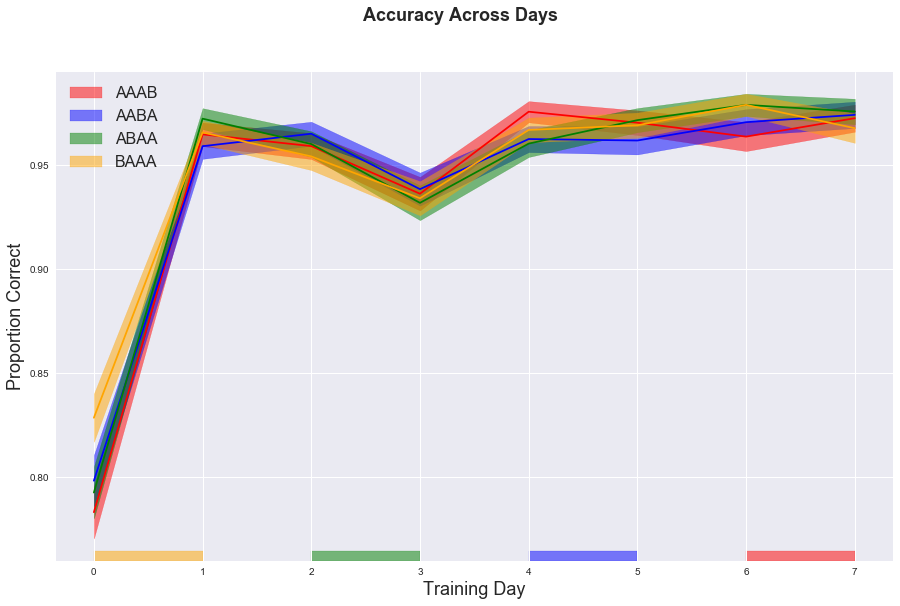

In [117]:
#make an array of means and SD (day x condition)   
means = np.zeros((8,4))
sd = np.zeros((8,4))
for day in range(8):
    for order in range(4):
        means[day, order] = np.mean(rts_all[day][order][:,8])#average RT
        sd[day, order] = ss.sem(rts_all[day][order][:,8])#Standard Error of the Mean 
        
#Plot the graph
rt_training = plt.figure(figsize=(15,9))
rt_training = plt.plot(range(len(means[:,0])), means[:,0], color = 'red')
rt_training = plt.fill_between(range(len(means[:,0])),means[:,0]-sd[:,0], means[:,0]+sd[:,0], alpha=0.5, color = 'red')
rt_training = plt.axvspan(6, 7, ymin=0, ymax=0.02, alpha = 0.5, color = 'red', zorder=0)
rt_training = plt.plot(means[:,1], color = 'blue')
rt_training = plt.fill_between(range(len(means[:,1])),means[:,1]-sd[:,1], means[:,1]+sd[:,1], alpha=0.5, color = 'blue')
rt_training = plt.axvspan(4, 5, ymin=0, ymax=0.02, alpha = 0.5, color = 'blue', zorder=0)
rt_training = plt.plot(means[:,2], color = 'green')
rt_training = plt.fill_between(range(len(means[:,2])),means[:,2]-sd[:,2], means[:,2]+sd[:,2], alpha=0.5, color = 'green')
rt_training = plt.axvspan(2, 3, ymin=0, ymax=0.02, alpha = 0.5, color = 'green', zorder=0)
rt_training = plt.plot(means[:,3], color = 'orange')
rt_training = plt.fill_between(range(len(means[:,3])),means[:,3]-sd[:,3], means[:,3]+sd[:,3], alpha=0.5, color = 'orange')
rt_training = plt.axvspan(0, 1, ymin=0, ymax=0.02, alpha = 0.5, color = 'orange', zorder=0)

#custom colour patches
red_patch = mpatches.Patch(color='red', label='AAAB', alpha=0.5)
blue_patch = mpatches.Patch(color='blue', label='AABA', alpha=0.5)
green_patch = mpatches.Patch(color='green', label='ABAA', alpha=0.5)
orange_patch = mpatches.Patch(color='orange', label='BAAA', alpha=0.5)

#Add legend to the plot: custom patches with manual text size                             
rt_training = plt.legend(handles=[red_patch, blue_patch, green_patch, orange_patch], prop={'size':16})

#Axis labels and plot title
rt_training = plt.ylabel('Proportion Correct', fontsize=18)
rt_training = plt.xlabel('Training Day', fontsize=18)
rt_training = plt.suptitle('Accuracy Across Days', fontsize=18, fontweight='bold')
#show the plot 
plt.show()

<a id='8'></a>

## Orienting Results 

Now let's look at the data from the orienting task. 

First we are going to do some pretty non-pythonic messing around with data structure (I am still learning).

In [30]:
#populate empty array - there was errors doing it in a more sensible way - first plotting script so lets see
orient= {}
all_orient= {}
for cond in range(2):
    orient[cond]= {}
    all_orient[cond]= {}
    for order in range(4):
        orient[cond][order]= []
        all_orient[cond][order]= []

#append rows to array - exception if non existent (i.e. missing days)
for part in partno:
        try:
            #only use correct trials 
            orient[0][0].append(np.array(data[part][8][(data[part][8]['correctdirection'] == 1) & (data[part][8]['condition'] == 1) & (data[part][8]['order'] == 1)]))
            orient[0][1].append(np.array(data[part][8][(data[part][8]['correctdirection'] == 1) & (data[part][8]['condition'] == 1) & (data[part][8]['order'] == 2)]))
            orient[0][2].append(np.array(data[part][8][(data[part][8]['correctdirection'] == 1) & (data[part][8]['condition'] == 1) & (data[part][8]['order'] == 3)]))
            orient[0][3].append(np.array(data[part][8][(data[part][8]['correctdirection'] == 1) & (data[part][8]['condition'] == 1) & (data[part][8]['order'] == 4)]))
            orient[1][0].append(np.array(data[part][8][(data[part][8]['correctdirection'] == 1) & (data[part][8]['condition'] == 2) & (data[part][8]['order'] == 1)]))
            orient[1][1].append(np.array(data[part][8][(data[part][8]['correctdirection'] == 1) & (data[part][8]['condition'] == 2) & (data[part][8]['order'] == 2)]))
            orient[1][2].append(np.array(data[part][8][(data[part][8]['correctdirection'] == 1) & (data[part][8]['condition'] == 2) & (data[part][8]['order'] == 3)]))
            orient[1][3].append(np.array(data[part][8][(data[part][8]['correctdirection'] == 1) & (data[part][8]['condition'] == 2) & (data[part][8]['order'] == 4)]))
            #all trials 
            all_orient[0][0].append(np.array(data[part][8][(data[part][8]['condition'] == 1) & (data[part][8]['order'] == 1) & (data[part][8]['correctdirection'] != 9)]))
            all_orient[0][1].append(np.array(data[part][8][(data[part][8]['condition'] == 1) & (data[part][8]['order'] == 2) & (data[part][8]['correctdirection'] != 9)]))
            all_orient[0][2].append(np.array(data[part][8][(data[part][8]['condition'] == 1) & (data[part][8]['order'] == 3) & (data[part][8]['correctdirection'] != 9)]))
            all_orient[0][3].append(np.array(data[part][8][(data[part][8]['condition'] == 1) & (data[part][8]['order'] == 4) & (data[part][8]['correctdirection'] != 9)]))
            all_orient[1][0].append(np.array(data[part][8][(data[part][8]['condition'] == 2) & (data[part][8]['order'] == 1) & (data[part][8]['correctdirection'] != 9)]))
            all_orient[1][1].append(np.array(data[part][8][(data[part][8]['condition'] == 2) & (data[part][8]['order'] == 2) & (data[part][8]['correctdirection'] != 9)]))
            all_orient[1][2].append(np.array(data[part][8][(data[part][8]['condition'] == 2) & (data[part][8]['order'] == 3) & (data[part][8]['correctdirection'] != 9)]))
            all_orient[1][3].append(np.array(data[part][8][(data[part][8]['condition'] == 2) & (data[part][8]['order'] == 4) & (data[part][8]['correctdirection'] != 9)]))
        except:
            pass 
        
#concat vertically all data in cells for each dayXcondition
for cond in range(2):
    for order in range(4):
        orient[cond][order] = np.vstack(orient[cond][order])
        all_orient[cond][order] = np.vstack(all_orient[cond][order])
        
# covert to DF because nested structure is actually a dict, which is not indexable by slices
orient = pd.DataFrame(orient)
all_orient = pd.DataFrame(all_orient)

<a id='9'></a>

### RT for conditions and order 

This will be two plots - one with RT by condition for all order, and one for condition x order. MATPLOTLIB with subplots. 

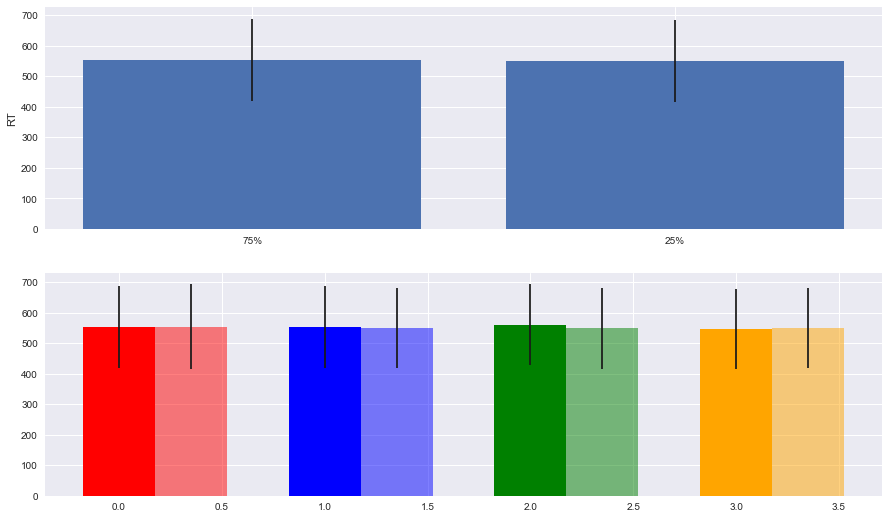

In [31]:
#Takes Means and Standard Error. 
#Due to the nested structure of orient (cond1[order1,2,3,4], cond2[order1,2,3,4]]) we have concat using np.vstack
cond_mean = np.array([np.mean(np.vstack(orient[0][:])[:,5]), np.mean(np.vstack(orient[1][:])[:,5])])
cond_error = np.array([np.std(np.vstack(orient[0][:])[:,5]), np.std(np.vstack(orient[1][:])[:,5])])

#make 2D array for this one. 2x4; condition x order
condxorder_mean = np.array([[np.mean(orient[0][0][:,5]), np.mean(orient[0][1][:,5]), np.mean(orient[0][2][:,5]), np.mean(orient[0][3][:,5])], [np.mean(orient[1][0][:,5]), np.mean(orient[1][1][:,5]), np.mean(orient[1][2][:,5]), np.mean(orient[1][3][:,5])]])
condxorder_error = np.array([[np.std(orient[0][0][:,5]), np.std(orient[0][1][:,5]), np.std(orient[0][2][:,5]), np.std(orient[0][3][:,5])], [np.std(orient[1][0][:,5]), np.std(orient[1][1][:,5]), np.std(orient[1][2][:,5]), np.std(orient[1][3][:,5])]])

f, rt_orient = plt.subplots(2, sharey=True, figsize=(15,9))

#First subplot - by condition
rt_orient[0].bar(range(len(cond_mean)), cond_mean*1000, 0.8, yerr = cond_error*1000)
rt_orient[0].set(ylabel="RT", xticks = np.arange(len(cond_mean)), xticklabels = ('75%', '25%'))

#second subplot - condition x order 
color_scheme = ['red', 'blue', 'green', 'orange']
rt_orient[1].bar(range(len(condxorder_mean[0])), condxorder_mean[0]*1000, 
                0.35, yerr = condxorder_error[0]*1000, label = '75%', color = color_scheme)
rt_orient[1].bar(np.arange(len(condxorder_mean[1])) + 0.35, condxorder_mean[1]*1000, 
                0.35, yerr = condxorder_error[1]*1000, label = '25%', color = color_scheme, alpha =0.5)
plt.show()

<a id='10'></a>

#### Distribution of RTs 
Using Seaborn let's quickly plot some distributions 


/Users/Alex/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


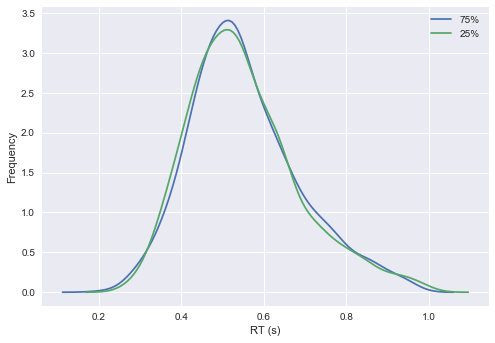

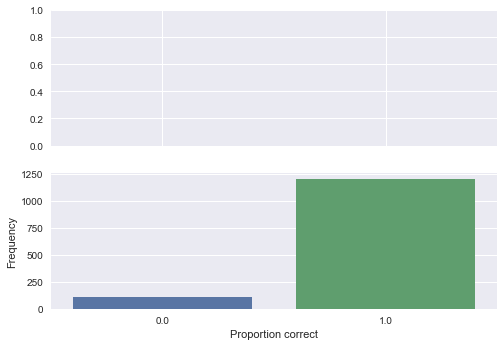

In [32]:
#RT 
rt_cond = sns.kdeplot((np.vstack(orient[0][:])[:,5]), label = "75%") #75%
rt_cond = sns.kdeplot((np.vstack(orient[1][:])[:,5]), label = "25%") #25%
rt_cond.set(xlabel='RT (s)', ylabel = 'Frequency')
plt.show()

y, acc_cond = plt.subplots(2, sharex = True)
acc_cond[0] = sns.countplot((np.vstack(all_orient[0][:])[:,12]), label = "75%") #75%
acc_cond[1] = sns.countplot((np.vstack(all_orient[1][:])[:,12]), label = "25%") #25%
acc_cond[0].set(xlabel='Proportion correct', ylabel = 'Frequency')
plt.show()

<a id='11'></a>

## Memtest Results 

Now let's look at memory accuracy, we can then look at differences in orienting rt between recall and non-recalled. 

We can look at explicit recall accuracy by comparing euclidian distance between clicked location and actual location. 


<a id='12'></a>

### Experimenting with concatenated data structure 
Up until this point I have used a nested pandas DataFrame structure to organise the data, after doing this I think it might be more efficient to concatenate all of the data, and dummy code things like participant and day. So lets try this below:


In [127]:
del(concat_data) #do this because of the use of in locals() loop, which would not recognise a re-run
for part in partno:
    for day in range(10):
        try:
            if 'concat_data' in locals():#does variable exist locally?
                temp_data = np.hstack((np.array(data[part][day]), np.reshape([part]*len(data[part][day]),(len(data[part][day]), 1)), np.reshape([day]*len(data[part][day]),(len(data[part][day]), 1))))
                concat_data=np.concatenate((concat_data, temp_data), axis=0)#concat
            else:
                concat_data=np.hstack((np.array(data[part][day]), np.reshape([part]*len(data[part][day]),(len(data[part][day]), 1)), np.reshape([day]*len(data[part][day]),(len(data[part][day]), 1))))
        except: #if it doesnt work because participant X has no data for that day
            pass

#Now we can easily subset data by any desired value 😊

<a id='13'></a>

### How accurate were clicks? 

It looks like the original coordinates for the two conditions in each image are missing. So we need to load in the configuration information for each participant, from this we can work out the two locations for each image, and then compare them to the actual clicked location in the memtest

So let's load in this config information: 

*note:* config days have this structure. [scenes_encoding,condition,order,quad1_encoding, quad2_encoding, isi,trg, x, y]

In [176]:
del(concat_conf)
for part in partno: #loop through participants
    
    with open(config_dir + str(part) + '.JSON') as data_file:    #open the file 
        data_temp = json.load(data_file)  #assign to temp variable 
    
    #We know there are 8 days in the training, each image switches at different days, so we must go through all days configurations
    #However all days contain the order information for a given image number.......
    #We can read this in from day1, then use this to find out which day the second coordinates are hidden in. 
    #loop for 192 images 
    for i in range(192):
        #values for this image:
        #for i in range(8)
        img_no = data_temp["Key"]["day1"][0][i]
        cond = data_temp["Key"]["day1"][1][i]
        order = data_temp["Key"]["day1"][2][i]
        if (order == 4):#if order is four, then the x,y coordinates given will be from the 25% condition
            x_2 = data_temp["Key"]["day1"][7][i]
            y_2 = data_temp["Key"]["day1"][8][i]
            #we will need to get the 75% location from elsewhere (the irregular days)
            #In this case we use day3, which will be the first day with new location! 
            #the i for i,x in enumerate(data_temp....).. finds the row number of the x,y for that image in day1
            #we can not do a simple [[0]==img_no] row number because it is a dictionary of lists rather than an array
            x_1 = data_temp["Key"]["day4"][7][[i for i,x in enumerate(data_temp["Key"]["day4"][0]) if x == img_no][0]]
            y_1 = data_temp["Key"]["day4"][8][[i for i,x in enumerate(data_temp["Key"]["day4"][0]) if x == img_no][0]]
        else:#if order is not four, then the x,y coordinates given will be from the 75% condition
            x_1 = data_temp["Key"]["day1"][7][i]
            y_1 = data_temp["Key"]["day1"][8][i]
            #to find out where the 25% coordinates are we will fetch this from order*2, this gives us the less commmon day
            x_2 = data_temp["Key"]["day" + str(2*(5-order))][7][[i for i,x in enumerate(data_temp["Key"]["day" + str(order*2)][0]) if x == img_no][0]]
            y_2 = data_temp["Key"]["day" + str(2*(5-order))][8][[i for i,x in enumerate(data_temp["Key"]["day" + str(order*2)][0]) if x == img_no][0]]
            
        if 'concat_conf' in locals():#does variable exist locally?
            concat_conf=np.vstack((concat_conf,np.array([img_no, cond, order, x_1, y_1, x_2, y_2, part])))
        else:
            concat_conf=np.array([img_no, cond, order, x_1, y_1, x_2, y_2, part])
        
    del(data_temp)



<a id='14'></a>

**Cartesian things:**
Okay, now we have this information (annoying it wasn't there) we can check whether the clicks in the memtest were accurate. 
We can do this using the Euclidean distance:
<p style="text-align: center;"> 
$Distance = \sqrt{(x_{2}-x_{1})^2 + (y_{2}-y_{1})^2}$
</p>

**In Python:**

    distance_1 = math.sqrt((memtest_data[row, 2]-ref_info[3])**2  +  (memtest_data[row, 3]-ref_info[4])**2)

    distance_2 = math.sqrt((memtest_data[row, 2]-ref_info[5])**2  +  (memtest_data[row, 3]-ref_info[6])**2)

We can also calculate this for each location that was clicked in the memtest. Comparing *each* click with *both* the possible locations, allows us to coarsely categorise the location it may have been refering too [WARNING: This may not be what they were doing, hence the word *coarsely*]. 

**Coordinate conversion**

Also we have to convert coordinates recorded from PyscoPy, where the center of the screen is (0px,0px) to JS, which are only in quadrant I of the cartesian plane, screen center is (500px,375px). This is because PsychoPy records clicks relative to the center, wheras Javascript records it relative to the image canvas. 

We can do this by the converting function: $f(x_{JS},y_{JS}) = x_{memtest}+500, y_{memtest}+375$

**Output**

The script below takes all of this information and outputs an array with the accuracy of clicks in each participant's memtest results. 

In [193]:
del(accu_array)
memtest_data = concat_data[(concat_data[:,14] == 9)] #select all memtest results
for row in range(len(memtest_dat)): #loop through each memtest result 
    no = memtest_data[row,13] #participant of current row
    image = memtest_data[row, 0] #image on current row 
    confid = memtest_data[row,9]
    ref_info = concat_conf[(concat_conf[:, 7] == no) & (concat_conf[:, 0] == image)][0] 
    
    #Euclidean distances between click and both learnt locations of the key: with conversion to common coord system
    eucl_1 = math.sqrt(((memtest_data[row, 2]+500)-ref_info[3])**2  +  ((memtest_data[row, 3]+375)-ref_info[4])**2)
    eucl_2 = math.sqrt(((memtest_data[row, 2]+500)-ref_info[5])**2  +  ((memtest_data[row, 3]+375)-ref_info[6])**2)
    
    #which one is best? Force to use on of the coordinates, flag which one (2=75%, 1=25%)
    if (eucl_1 > eucl_2):
        eucl = eucl_2
        eucl2 = eucl_1
        target = 2
    else: 
        eucl = eucl_1
        eucl2 = eucl_2
        target = 1 
    
    if 'accu_array' in locals(): #if this is not the first loop and array exists
        accu_array = np.vstack((accu_array, np.array([image, confid, eucl, eucl2, target, no])))
    else: #if first loop create the array
        accu_array = np.array([image, confid, eucl2, eucl, target, no])

<a id='15'></a>

### Confidence Accuracy?

OK, so let's look if the confidence ratings people gave for their two clicks per image have a statistically significant relationship?

This can be done with a simple one way ANOVA using scipy stats. Then plotted in matplotlib

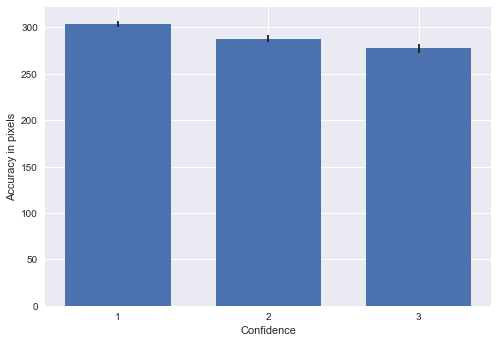

ANOVA One Way, F =  12.9959754828  P-Value =  0.0000023368


In [229]:
#accuracy of closest click means and error from each confidence rating 
acc_means = (np.mean(accu_array[:,2][accu_array[:,1] == 1]), np.mean(accu_array[:,2][accu_array[:,1] == 2]), np.mean(accu_array[:,2][accu_array[:,1] == 3]))
degrees_free = len(np.unique(accu_array[:,5]))
acc_err = (ss.sem(accu_array[:,2][accu_array[:,1] == 1], ddof=degrees_free), ss.sem(accu_array[:,2][accu_array[:,1] == 2], ddof=degrees_free), ss.sem(accu_array[:,2][accu_array[:,1] == 3], ddof=degrees_free))

#locations and widths of bars
ind = np.arange(3)
width = 0.7

#make figure
conf_acc = plt.figure()
conf_acc = plt.bar(ind+width, acc_means, width, yerr=acc_err)

#custom labels
# add some text for labels, title and axes ticks
conf_acc= plt.ylabel('Accuracy in pixels')
conf_acc= plt.xlabel('Confidence')
conf_acc= plt.xticks(ind + width , ['1', '2', '3'])

plt.show()

#Are there differences in an one way ANOVA ?
ANOVA = ss.f_oneway(accu_array[:,2][accu_array[:,1] == 1], accu_array[:,2][accu_array[:,1] == 2], accu_array[:,2][accu_array[:,1] == 3])
print('ANOVA One Way, F = ', ANOVA[0] , ' P-Value = ', "%.10f" %ANOVA[1])


Great! There is a small (but significantly significant) association between confidence and accuracy. 